In [1]:
import mne
import re
import os
import numpy as np
import source_localization as srcl
import MEG_analysis as meg
import machine_learning as ml
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef)

%matplotlib inline

In [2]:
folder_dict = meg.get_folder_dict()
subj = 'MF-aligned'
meg_dir = '../../../../MEG_raw01/170131_fujita_SD'
should_save_evoked_figs = False
should_train_model = True
source_localization_dir = "/usr/local/freesurfer/subjects"

In [3]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)
src, bem = srcl.get_processed_mri_data(subj, source_localization_dir)
cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)
fwd = srcl.make_forward_sol(evoked, src, bem, "%s/%s-trans.fif" % (meg_dir, subj))

Reading ../Data/Epochs/MF-aligned-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
600 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 project

In [4]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7955/8196 = 10.006844
    scale = 1.91128e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 8.4e-14 (2.2e-16 eps * 204 dim * 1.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [5]:
X = np.array([next(stc_epoch).lh_data for i in range(100)])
print(X.shape)

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 5)
    Created the whitener using a noise covariance matrix with rank 199 (5 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 204 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 600
combining the current components...
Processing epoch : 2 / 600
combining the current components...
Processing epoch : 3 / 600
combining the current components...
Processing epoch : 4 / 600
combining the current components...
Processing epoch : 5 / 600
combining the current components...
Processing epoch : 6 / 600
combining the current components...
Processing epoch : 7 / 600
combining the current components...
Processing epoch : 8 / 600
combining the current components...
Processing epoch : 9 / 600
combining the curr

In [6]:
path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block1_data.mat"
y = np.array(ml.classify_target_gabors(path))
print(y.shape)
print(y)

(100,)
[0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 0 0 1 1
 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1
 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 0 0]


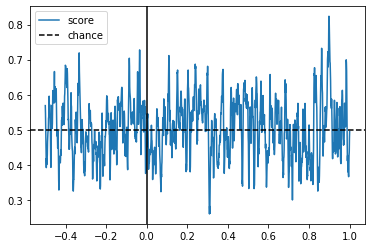

In [7]:
# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=500),  # select features for speed
                    LinearModel(LogisticRegression(C=1, solver='liblinear')))

time_decod = SlidingEstimator(clf, scoring='roc_auc')
scores = cross_val_multiscore(time_decod, X, y, cv=5, n_jobs=1)

# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(epochs.times, scores.mean(0), label='score')
ax.axhline(.5, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()